In [10]:
from SimPEG import *
from SimPEG import EM
from scipy.constants import mu_0
import numpy as np
import scipy.sparse as sp
from simpegEMIP.StretchedExponential import SEInvImpulseProblem, SESurvey
import matplotlib.pyplot as plt
from pymatsolver import PardisoSolver
import matplotlib.patches as mpatches
from matplotlib.collections import PatchCollection
def rect2D(p1, p2):    
    xy = np.c_[np.r_[p1[0], p2[0], p2[0], p1[0], p1[0]], np.r_[p1[1], p1[1], p2[1], p2[1], p1[1]]]
    return xy
%matplotlib inline

In [11]:
figdir = "./figures/"

In [12]:
from scipy.signal import square
from scipy.fftpack import fft, fftshift
def rect_time_to_frequency(dt, f_base, n_period=2):
    T_base = 1./f_base
    n = int(np.floor(T_base/dt)*n_period)
    t = np.linspace(0., n*dt, n)
    out_t = square(2 * np.pi * f_base * t, duty=0.5)
    out_f = fft(out_t) * 2.0/n
    f = np.linspace(0., 1./(2.*dt), n//2)
    out = {"t":t, "f":f[0:n//2], "out_t": out_t, "out_f":out_f[0:n//2]}
    return out

Text(0.5, 0, 'Time (s)')

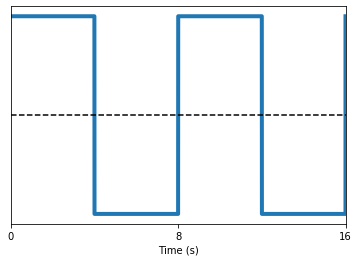

In [13]:
out_grounded = rect_time_to_frequency(1e-4, 0.125, 2)
out_aem = rect_time_to_frequency(1e-6, 25., 4)

plt.plot(out_grounded['t'], out_grounded['out_t'], lw=4)
plt.plot(np.r_[0, 16], np.r_[0., 0.], 'k--')
plt.xlim(0, 16)
plt.xticks([0., 8., 16.])
plt.yticks([])
plt.xlabel("Time (s)")

Text(0.5, 0, 'Time (s)')

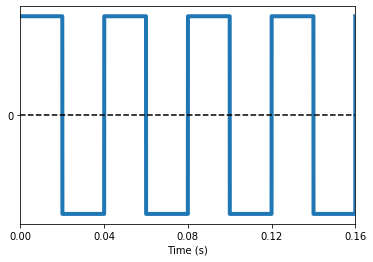

In [14]:
plt.plot(out_aem['t'], out_aem['out_t'], lw=4)
plt.xlim(0, out_aem['t'].max())
plt.plot(np.r_[0, out_aem['t'].max()], np.r_[0., 0.], 'k--')
plt.xticks([0,1./25, 2./25, 3./25, 4./25])
plt.yticks([0.])
plt.xlabel("Time (s)")

Text(0.5, 0, 'Frequency (Hz)')

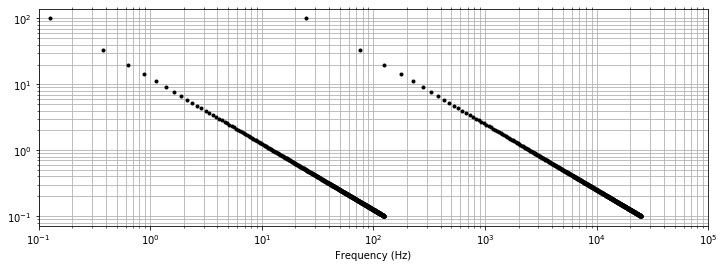

In [15]:
plt.figure(figsize = (12, 4))
temp_grounded = abs(out_grounded['out_f'])/abs(out_grounded['out_f']).max()
inds = temp_grounded>1e-3
plt.loglog(out_grounded['f'][inds], temp_grounded[inds]*100., 'k.')
temp_aem = abs(out_aem['out_f'])/abs(out_aem['out_f']).max()
inds = temp_aem>1e-3
plt.loglog(out_aem['f'][inds], temp_aem[inds]*100., 'k.')
fmin_grounded, fmax_grounded = out_grounded['f'][inds].min(), out_grounded['f'][inds].max()
fmin_aem, fmax_aem = out_aem['f'][inds].min(), out_aem['f'][inds].max()
plt.xlim(1e-1, 1e5)
plt.gca().tick_params(axis='x',which='minor', bottom='on', top='on')
plt.grid(which='both')
plt.xlabel("Frequency (Hz)")

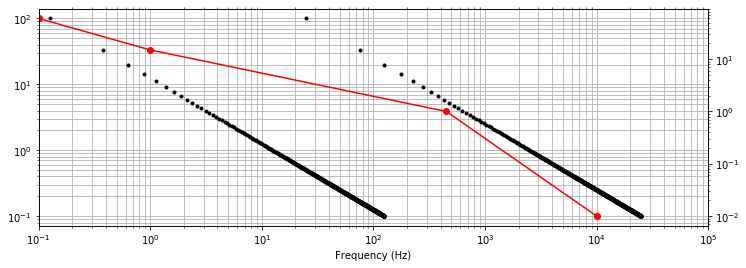

In [16]:
from scipy.interpolate import interp1d
grain_size = np.array([0.01, 1, 15, 60])
frequency_grain_size = np.array([1e4, 450., 1., 0.1])
grain_size_fun = interp1d(frequency_grain_size, grain_size)
plt.figure(figsize = (12, 4))
temp_grounded = abs(out_grounded['out_f'])/abs(out_grounded['out_f']).max()
inds = temp_grounded>1e-3
ax = plt.subplot(111)
ax.loglog(out_grounded['f'][inds], temp_grounded[inds]*100., 'k.')
temp_aem = abs(out_aem['out_f'])/abs(out_aem['out_f']).max()
inds = temp_aem>1e-3
ax.loglog(out_aem['f'][inds], temp_aem[inds]*100., 'k.')
fmin_grounded, fmax_grounded = out_grounded['f'][inds].min(), out_grounded['f'][inds].max()
fmin_aem, fmax_aem = out_aem['f'][inds].min(), out_aem['f'][inds].max()
ax.set_xlim(1e-1, 1e5)
ax.tick_params(axis='x',which='minor', bottom='on', top='on')
ax.grid(which='both')
ax.set_xlabel("Frequency (Hz)")
ax_1 = ax.twinx()
ax_1.loglog(frequency_grain_size, grain_size, 'ro-')

In [17]:
def tau_from_peak_freq(f):
    return 1./(2*np.pi*f)

In [18]:
freqs = 10.**(-1 + np.arange(7))
taus = tau_from_peak_freq(freqs)

In [19]:
import matplotlib 
matplotlib.rcParams["font.size"] = 16
matplotlib.rcParams["image.cmap"] = "RdBu_r"
# fig_dir = "../../docs/figures/"

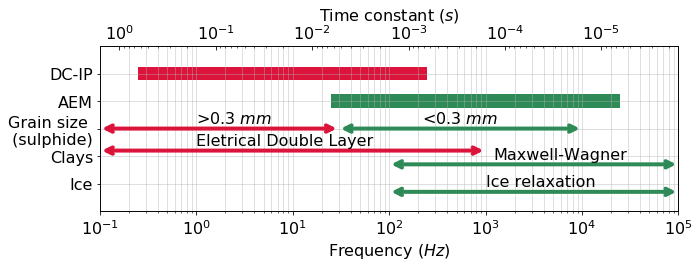

In [20]:
fig = plt.figure(figsize = (10, 4))
ax = plt.subplot(111)
ax.set_xlim(1e-1, 1e5)
ax.set_xscale('log')
ax.grid(which='both', alpha=0.5)
ax.set_xlabel("Frequency ($Hz$)")
ax.barh(4, fmax_grounded-fmin_grounded, 0.5, fmin_grounded, color='crimson')
ax.barh(3, fmax_aem-fmin_aem, 0.5, fmin_aem, color='seagreen')
ax.annotate(
    s='', xy=(30.,2), xytext=(0.1,2), arrowprops=dict(arrowstyle='<->',fc="crimson", ec="crimson", lw=4)
)
ax.annotate(
    s='', xy=(1e4,2), xytext=(30.,2), arrowprops=dict(arrowstyle='<->',fc="seagreen", ec="seagreen", lw=4)
)
ax.annotate(
    s='', xy=(1e3,1.2), xytext=(0.1,1.2), arrowprops=dict(arrowstyle='<->',fc="crimson", ec="crimson", lw=4)
)
ax.annotate(
    s='', xy=(1e5,0.7), xytext=(1e2,0.7), arrowprops=dict(arrowstyle='<->',fc="seagreen", ec="seagreen", lw=4)
)

ax.annotate(
    s='', xy=(1e5,-0.3), xytext=(1e2,-0.3), arrowprops=dict(arrowstyle='<->',fc="seagreen", ec="seagreen", lw=4)
)
tau_min, tau_max = taus.min(), taus.max()
axT = ax.twiny()
axT.set_xlim(tau_max, tau_min)

axT.tick_params(which='both', direction = 'in')
axT.set_xscale('log')
axT.set_xlabel('Time constant ($s$)')
ax.text(1, 2.2, ">0.3 $mm$")
ax.text(220, 2.2, "<0.3 $mm$")
ax.text(1, 1.4, "Eletrical Double Layer")
ax.text(1.2*1e3, 1.2-0.3, "Maxwell-Wagner")
ax.text(1*1e3, 1.2-0.3-1, "Ice relaxation")

ax.set_ylim(-1, 5)
ax.set_yticks([0, 1, 2, 3, 4])
ax.set_yticklabels(["Ice", "Clays", "Grain size \n (sulphide)", "AEM", "DC-IP"])
plt.tight_layout()
fig.savefig(figdir + "polarization_spectrum")

In [21]:
def ColeCole(sigmaInf, tau, eta, c, frequency):
    w = 2*np.pi*f
    dsig = -sigmaInf * eta / (1. + (1j*omega*tau)**c)
    return sigmaInf + dsig

In [22]:
from simpegEMIP.SeogiUtils.View import Rectangle2D

In [23]:
rxloc = np.array([[0., 0., 30.]])
srcloc = np.array([[0., 0., 30.]])

In [24]:
from simpegEMIP.TDEM import Problem3D_e, Problem3DEM_e, Rx, Survey

In [25]:
cs, ncx, ncz, npad = 10., 25, 20, 20
hx = [(cs,ncx), (cs,npad,1.3)]
hz = [(cs,npad,-1.3), (cs,ncz), (cs,npad,1.3)]
mesh = Mesh.CylMesh([hx,1,hz], '00C')    
sig_2 = 0.1
sig_1 = 0.0001
etas = [0.1, 0.2, 0.3, 0.4, 0.5]
data_list_eta = []
data_em_list_eta = []
data_ip_list_eta = []
for i, eta_temp in enumerate(etas):    
    sigmaInf = np.ones(mesh.nC) * sig_1
    airind = mesh.gridCC[:,2]>0.
    blkind  = np.logical_and(mesh.gridCC[:,0]<200., (mesh.gridCC[:,2]<0)&(mesh.gridCC[:,2]>-150)&(mesh.gridCC[:,2]<-50))
    sigmaInf[airind] = 1e-8
    sigmaInf[blkind] = sig_2
    eta_CC, tau_CC, c_CC = eta_temp, 0.001, 0.7
    print (eta_CC, tau_CC, c_CC)
    eta = np.zeros(mesh.nC)
    eta[blkind] = eta_CC
    tau = np.ones(mesh.nC) * tau_CC
    c = np.ones(mesh.nC) * c_CC 

    rx_emip = Rx.Point_dbdt(rxloc, np.logspace(np.log10(1e-5), np.log10(0.009), 51), 'z')
    src_emip = EM.TDEM.Src.CircularLoop([rx_emip], waveform=EM.TDEM.Src.StepOffWaveform(), loc=srcloc, radius = 13.)
    survey_emip = Survey([src_emip])
    prb_emip = Problem3D_e(mesh, sigmaInf=sigmaInf, eta=eta, tau=tau, c=c)
    prb_emip.timeSteps = [(1e-06, 5), (2.5e-06, 5), (5e-06, 5), (1e-05, 10), (2e-05, 10), (4e-05, 10), (8e-05, 10), (1.6e-04, 10), (3.2e-04, 20)]
    prb_emip.Solver = PardisoSolver
    prb_emip.pair(survey_emip)
    m = np.r_[sigmaInf, eta, tau, c]
    data = survey_emip.dpred(m)
    data_list_eta.append(data) 
    
    rx_em = EM.TDEM.Rx.Point_dbdt(rxloc, np.logspace(np.log10(1e-5), np.log10(0.009), 51), 'z')
    src_em = EM.TDEM.Src.CircularLoop([rx_em], waveform=EM.TDEM.Src.StepOffWaveform(), loc=srcloc, radius = 13.)
    survey_em = EM.TDEM.Survey([src_em])
#     prb_em = Problem3D_e(mesh, sigmaInf=sigmaInf, eta=eta*0., tau=tau, c=c)
    if i==0:
        prb_em = EM.TDEM.Problem3D_e(mesh, sigma=sigmaInf)
        prb_em.timeSteps = [(1e-06, 5), (2.5e-06, 5), (5e-06, 5), (1e-05, 10), (2e-05, 10), (4e-05, 10), (8e-05, 10), (1.6e-04, 10), (3.2e-04, 20)]
        prb_em.Solver = PardisoSolver
        prb_em.pair(survey_em)
        m = np.r_[sigmaInf, eta, tau, c]
        data_em = survey_em.dpred(m)
    data_ip_list_eta.append(data - data_em)

0.1 0.001 0.7


/Users/sgkang/Projects/simpeg/SimPEG/Props.py:400: UserWarning: Cannot add model as there are no active mappings, choose from: ['cMap', 'etaMap', 'rhoMap', 'sigmaInfMap', 'sigmaMap', 'tauMap']
  "', '".join(self._all_map_names)
/Users/sgkang/Projects/simpeg/SimPEG/Props.py:400: UserWarning: Cannot add model as there are no active mappings, choose from: ['rhoMap', 'sigmaMap']
  "', '".join(self._all_map_names)


0.2 0.001 0.7
0.3 0.001 0.7
0.4 0.001 0.7
0.5 0.001 0.7


In [26]:
from simpegEMIP.TDEM.Utils import get_dobs_pn
moment = np.pi*src_emip.radius**2 / 1e12

Text(0.03, 0.0005, 'Greay area: <$|d^{F}|$')

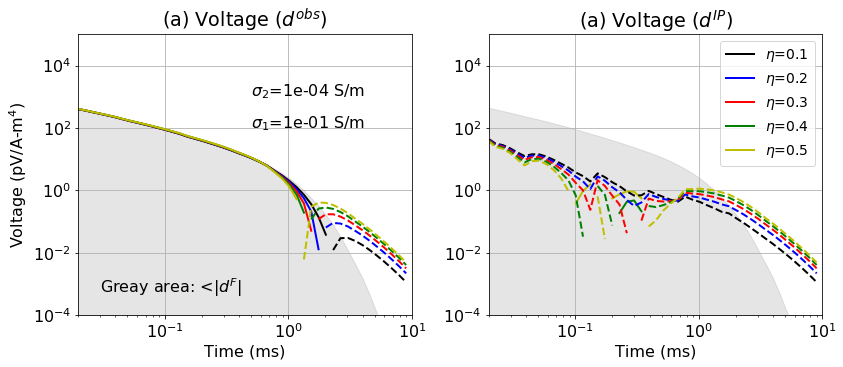

In [27]:
fig = plt.figure(figsize = (12, 5))
ax = plt.subplot(121)
ax1 = plt.subplot(122)
legends = [("$\eta$=%.1f ")%(eta_temp) for eta_temp in etas]
ms = 1e3
colors = ["k", "b", "r", "g", 'y', 'purple', 'grey', 'skyblue', 'seagreen']
for i in range(5):
    data_p, data_n = get_dobs_pn(data_list_eta[i].flatten()/moment)
    ax.loglog(rx_emip.times*ms, data_n, linestyle='-', color=colors[i], lw=2)
    ax.loglog(rx_emip.times*ms, data_p, linestyle='--', color=colors[i], lw=2)
for i in range(5):
    data_p, data_n = get_dobs_pn(data_ip_list_eta[i].flatten()/moment)
    ax1.loglog(rx_emip.times*ms, data_n, linestyle='-', color=colors[i], lw=2)
ax1.legend(legends, fontsize=14)
for i in range(5):
    data_p, data_n = get_dobs_pn(data_ip_list_eta[i].flatten()/moment)
    ax1.loglog(rx_emip.times*ms, data_p, linestyle='--', color=colors[i], lw=2)
    
for ax_temp in [ax, ax1]:
    ax_temp.set_xlabel("Time (ms)")        
    ax_temp.set_xlim(2e-5*ms, 0.01*ms)
    ax_temp.grid()
    ax_temp.set_ylim(1e-4, 1e5)
    ax_temp.fill_between(rx_emip.times*ms, -data_em.flatten()/moment, 1e-4*np.ones_like(rx_emip.times), color='grey', alpha=0.2)        
ax.set_ylabel("Voltage (pV/A-m$^4$)")    
plt.tight_layout()    
ax.set_title("(a) Voltage ($d^{obs}$)")
ax1.set_title("(a) Voltage ($d^{IP}$)")
ax.text(0.5, 1e3, ("$\sigma_2$=%.0e S/m")%(1e-4))
ax.text(0.5, 1e2, ("$\sigma_1$=%.0e S/m")%(1e-1))
ax.text(3e-2, 5e-4, "Greay area: <$|d^{F}|$")
# fig.savefig(figdir+"data", dpi=300)

In [28]:
cs, ncx, ncz, npad = 10., 25, 20, 20
hx = [(cs,ncx), (cs,npad,1.3)]
hz = [(cs,npad,-1.3), (cs,ncz), (cs,npad,1.3)]
mesh = Mesh.CylMesh([hx,1,hz], '00C')    
sig_2 = 0.1
sig_1 = 0.0001
taus = [10., 1, 0.1, 0.01, 0.001]
data_list_tau = []
data_em_list_tau = []
data_ip_list_tau = []
for i, tau_temp in enumerate(taus):    
    sigmaInf = np.ones(mesh.nC) * sig_1
    airind = mesh.gridCC[:,2]>0.
    blkind  = np.logical_and(mesh.gridCC[:,0]<200., (mesh.gridCC[:,2]<0)&(mesh.gridCC[:,2]>-150)&(mesh.gridCC[:,2]<-50))
    sigmaInf[airind] = 1e-8
    sigmaInf[blkind] = sig_2
    eta_CC, tau_CC, c_CC = 0.1, tau_temp, 0.5
    print (eta_CC, tau_CC, c_CC)
    eta = np.zeros(mesh.nC)
    eta[blkind] = eta_CC
    tau = np.ones(mesh.nC) * tau_CC
    c = np.ones(mesh.nC) * c_CC 

    rx_emip = Rx.Point_dbdt(rxloc, np.logspace(np.log10(1e-5), np.log10(0.009), 51), 'z')
    src_emip = EM.TDEM.Src.CircularLoop([rx_emip], waveform=EM.TDEM.Src.StepOffWaveform(), loc=srcloc, radius = 13.)
    survey_emip = Survey([src_emip])
    prb_emip = Problem3D_e(mesh, sigmaInf=sigmaInf, eta=eta, tau=tau, c=c)
    prb_emip.timeSteps = [(5e-07, 5), (1e-06, 5), (2.5e-06, 5), (5e-06, 5), (1e-05, 10), (2e-05, 10), (4e-05, 10), (8e-05, 10), (1.6e-04, 10), (3.2e-04, 20)]
    prb_emip.Solver = PardisoSolver
    prb_emip.pair(survey_emip)
    m = np.r_[sigmaInf, eta, tau, c]
    data = survey_emip.dpred(m)
    data_list_tau.append(data) 
    
    rx_em = EM.TDEM.Rx.Point_dbdt(rxloc, np.logspace(np.log10(1e-5), np.log10(0.009), 51), 'z')
    src_em = EM.TDEM.Src.CircularLoop([rx_em], waveform=EM.TDEM.Src.StepOffWaveform(), loc=srcloc, radius = 13.)
    survey_em = EM.TDEM.Survey([src_em])
#     prb_em = Problem3D_e(mesh, sigmaInf=sigmaInf, eta=eta*0., tau=tau, c=c)
    if i==0:
        prb_em = EM.TDEM.Problem3D_e(mesh, sigma=sigmaInf)
        prb_em.timeSteps = [(5e-07, 5), (1e-06, 5), (2.5e-06, 5), (5e-06, 5), (1e-05, 10), (2e-05, 10), (4e-05, 10), (8e-05, 10), (1.6e-04, 10), (3.2e-04, 20)]
        prb_em.Solver = PardisoSolver
        prb_em.pair(survey_em)
        m = np.r_[sigmaInf, eta, tau, c]
        data_em = survey_em.dpred(m)
    data_ip_list_tau.append(data - data_em)

0.1 10.0 0.5
0.1 1 0.5
0.1 0.1 0.5
0.1 0.01 0.5
0.1 0.001 0.5


Text(0.03, 0.0005, 'Greay area: <$|d^{F}|$')

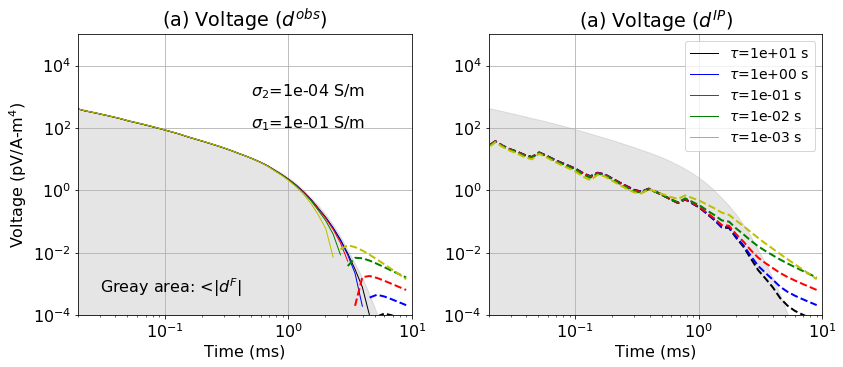

In [29]:
fig = plt.figure(figsize = (12, 5))
ax = plt.subplot(121)
ax1 = plt.subplot(122)
legends = [("$\\tau$=%.0e s")%(tau_temp) for tau_temp in taus]
ms = 1e3
colors = ["k", "b", "r", "g", 'y', 'purple', 'grey', 'skyblue', 'seagreen']
for i in range(5):
    data_p, data_n = get_dobs_pn(data_list_tau[i].flatten()/moment)
    ax.loglog(rx_emip.times*ms, data_n, linestyle='-', color=colors[i], lw=1)
    ax.loglog(rx_emip.times*ms, data_p, linestyle='--', color=colors[i], lw=2)
for i in range(5):
    data_p, data_n = get_dobs_pn(data_ip_list_tau[i].flatten()/moment)
    ax1.loglog(rx_emip.times*ms, data_n, linestyle='-', color=colors[i], lw=1)
ax1.legend(legends, fontsize=14)
for i in range(5):
    data_p, data_n = get_dobs_pn(data_ip_list_tau[i].flatten()/moment)
    ax1.loglog(rx_emip.times*ms, data_p, linestyle='--', color=colors[i], lw=2)
#     ax1.loglog(rx_emip.times*ms, -data_em.flatten()/moment, marker='x', color=colors[i], lw=2)

for ax_temp in [ax, ax1]:
    ax_temp.set_xlabel("Time (ms)")        
    ax_temp.set_xlim(2e-5*ms, 0.01*ms)
    ax_temp.grid()
    ax_temp.set_ylim(1e-4, 1e5)
    ax_temp.fill_between(rx_emip.times*ms, -data_em.flatten()/moment, 1e-4*np.ones_like(rx_emip.times), color='grey', alpha=0.2)    
ax.set_ylabel("Voltage (pV/A-m$^4$)")    
plt.tight_layout()    
ax.set_title("(a) Voltage ($d^{obs}$)")
ax1.set_title("(a) Voltage ($d^{IP}$)")
ax.text(0.5, 1e3, ("$\sigma_2$=%.0e S/m")%(1e-4))
ax.text(0.5, 1e2, ("$\sigma_1$=%.0e S/m")%(1e-1))
ax.text(3e-2, 5e-4, "Greay area: <$|d^{F}|$")
# fig.savefig(figdir+"data", dpi=300)

In [30]:
cs, ncx, ncz, npad = 10., 25, 20, 20
hx = [(cs,ncx), (cs,npad,1.3)]
hz = [(cs,npad,-1.3), (cs,ncz), (cs,npad,1.3)]
mesh = Mesh.CylMesh([hx,1,hz], '00C')    
sig_2 = 0.1
sig_1 = 0.0001
cs = [0.1, 0.3, 0.5, 0.7, 0.9, 1.]
data_list_c = []
data_em_list_c = []
data_ip_list_c = []
for i, c_temp in enumerate(cs):    
    sigmaInf = np.ones(mesh.nC) * sig_1
    airind = mesh.gridCC[:,2]>0.
    blkind  = np.logical_and(mesh.gridCC[:,0]<200., (mesh.gridCC[:,2]<0)&(mesh.gridCC[:,2]>-150)&(mesh.gridCC[:,2]<-50))
    sigmaInf[airind] = 1e-8
    sigmaInf[blkind] = sig_2
    eta_CC, tau_CC, c_CC = 0.1, 0.001, c_temp
    print (eta_CC, tau_CC, c_CC)
    eta = np.zeros(mesh.nC)
    eta[blkind] = eta_CC
    tau = np.ones(mesh.nC) * tau_CC
    c = np.ones(mesh.nC) * c_CC 

    rx_emip = Rx.Point_dbdt(rxloc, np.logspace(np.log10(1e-5), np.log10(0.009), 51), 'z')
    src_emip = EM.TDEM.Src.CircularLoop([rx_emip], waveform=EM.TDEM.Src.StepOffWaveform(), loc=srcloc, radius = 13.)
    survey_emip = Survey([src_emip])
    prb_emip = Problem3D_e(mesh, sigmaInf=sigmaInf, eta=eta, tau=tau, c=c)
    prb_emip.timeSteps = [(5e-07, 5), (1e-06, 5), (2.5e-06, 5), (5e-06, 5), (1e-05, 10), (2e-05, 10), (4e-05, 10), (8e-05, 10), (1.6e-04, 10), (3.2e-04, 20)]
    prb_emip.Solver = PardisoSolver
    prb_emip.pair(survey_emip)
    m = np.r_[sigmaInf, eta, tau, c]
    data = survey_emip.dpred(m)
    data_list_c.append(data) 
    
    rx_em = EM.TDEM.Rx.Point_dbdt(rxloc, np.logspace(np.log10(1e-5), np.log10(0.009), 51), 'z')
    src_em = EM.TDEM.Src.CircularLoop([rx_em], waveform=EM.TDEM.Src.StepOffWaveform(), loc=srcloc, radius = 13.)
    survey_em = EM.TDEM.Survey([src_em])
#     prb_em = Problem3D_e(mesh, sigmaInf=sigmaInf, eta=eta*0., tau=tau, c=c)
    if i==0:
        prb_em = EM.TDEM.Problem3D_e(mesh, sigma=sigmaInf)
        prb_em.timeSteps = [(5e-07, 5), (1e-06, 5), (2.5e-06, 5), (5e-06, 5), (1e-05, 10), (2e-05, 10), (4e-05, 10), (8e-05, 10), (1.6e-04, 10), (3.2e-04, 20)]
        prb_em.Solver = PardisoSolver
        prb_em.pair(survey_em)
        m = np.r_[sigmaInf, eta, tau, c]
        data_em = survey_em.dpred(m)
    data_ip_list_c.append(data - data_em)

0.1 0.001 0.1
0.1 0.001 0.3
0.1 0.001 0.5
0.1 0.001 0.7
0.1 0.001 0.9
0.1 0.001 1.0


In [31]:
# fig = plt.figure(figsize = (12, 5))
# ax = plt.subplot(121)
# ax1 = plt.subplot(122)
# legends = [("c=%.1f")%(c_temp) for c_temp in cs]
# ms = 1e3
# colors = ["k", "b", "r", "g", 'y', 'purple', 'grey', 'skyblue', 'seagreen']
# for i in range(5):
#     data_p, data_n = get_dobs_pn(data_list_c[i].flatten()/moment)
#     ax.loglog(rx_emip.times*ms, data_n, linestyle='-', color=colors[i], lw=1)
#     ax.loglog(rx_emip.times*ms, data_p, linestyle='--', color=colors[i], lw=2)
# ax.fill_between(rx_emip.times*ms, -data_em.flatten()/moment, 1e-4*np.ones_like(rx_emip.times), color='grey', alpha=0.2)
# for i in range(5):
#     data_p, data_n = get_dobs_pn(data_ip_list_c[i].flatten()/moment)
#     ax1.loglog(rx_emip.times*ms, data_n, linestyle='-', color=colors[i], lw=1)
# ax1.legend(legends, fontsize=14)
# for i in range(5):
#     data_p, data_n = get_dobs_pn(data_ip_list_c[i].flatten()/moment)
#     ax1.loglog(rx_emip.times*ms, data_p, linestyle='--', color=colors[i], lw=2)
    
# ax1.fill_between(rx_emip.times*ms, -data_em.flatten()/moment, 1e-4*np.ones_like(rx_emip.times), color='grey', alpha=0.2, lw=0.)
    
# for ax_temp in [ax, ax1]:
#     ax_temp.set_xlabel("Time (ms)")        
#     ax_temp.set_xlim(2e-5*ms, 0.01*ms)
#     ax_temp.grid()
#     ax_temp.set_ylim(1e-4, 1e5)
# ax.set_ylabel("Voltage (pV/A-m$^4$)")    
# plt.tight_layout()    
# ax.set_title("(a) Voltage ($d^{obs}$)")
# ax1.set_title("(a) Voltage ($d^{IP}$)")
# ax.text(0.5, 1e3, ("$\sigma_2$=%.0e S/m")%(1e-4))
# ax.text(0.5, 1e2, ("$\sigma_1$=%.0e S/m")%(1e-1))
# ax.text(3e-2, 5e-4, "Greay area: <$|d^{F}|$")

# Type Curves

## TypeA: Clay, Kimberlite, and Fine-grained sulphies

In [32]:
cs, ncx, ncz, npad = 10., 25, 20, 20
hx = [(cs,ncx), (cs,npad,1.3)]
hz = [(cs,npad,-1.3), (cs,ncz), (cs,npad,1.3)]
mesh = Mesh.CylMesh([hx,1,hz], '00C')    
data_list_typeA = []
data_em_list_typeA = []
data_ip_list_typeA = []
for i in range(2):
    airind = mesh.gridCC[:,2]>0.
    blkind  = np.logical_and(mesh.gridCC[:,0]<200., (mesh.gridCC[:,2]<0)&(mesh.gridCC[:,2]>-150)&(mesh.gridCC[:,2]<-50))    
    sigmaInf[airind] = 1e-8
    
    if i==0:
        sig_2 = 1./50
        sig_1 = 0.001
        eta_CC, tau_CC, c_CC = 0.1, 0.001, 0.7
    elif i==1:
        sig_2 = 1./50
        sig_1 = 0.001
        eta_CC, tau_CC, c_CC = 0.2, 0.001, 0.3
    
    sigmaInf = np.ones(mesh.nC) * sig_1
    sigmaInf[blkind] = sig_2
    eta = np.zeros(mesh.nC)
    eta[blkind] = eta_CC
    tau = np.ones(mesh.nC) * tau_CC
    c = np.ones(mesh.nC) * c_CC 

    rx_emip = Rx.Point_dbdt(rxloc, np.logspace(np.log10(1e-5), np.log10(0.009), 51), 'z')
    src_emip = EM.TDEM.Src.CircularLoop([rx_emip], waveform=EM.TDEM.Src.StepOffWaveform(), loc=srcloc, radius = 13.)
    survey_emip = Survey([src_emip])
    prb_emip = Problem3D_e(mesh, sigmaInf=sigmaInf, eta=eta, tau=tau, c=c)
    prb_emip.timeSteps = [(1e-06, 5), (2.5e-06, 5), (5e-06, 5), (1e-05, 10), (2e-05, 10), (4e-05, 10), (8e-05, 10), (1.6e-04, 10), (3.2e-04, 20)]
    prb_emip.Solver = PardisoSolver
    prb_emip.pair(survey_emip)
    m = np.r_[sigmaInf, eta, tau, c]
    data = survey_emip.dpred(m)
    data_list_typeA.append(data) 

    rx_em = EM.TDEM.Rx.Point_dbdt(rxloc, np.logspace(np.log10(1e-5), np.log10(0.009), 51), 'z')
    src_em = EM.TDEM.Src.CircularLoop([rx_em], waveform=EM.TDEM.Src.StepOffWaveform(), loc=srcloc, radius = 13.)
    survey_em = EM.TDEM.Survey([src_em])
    prb_em = EM.TDEM.Problem3D_e(mesh, sigma=sigmaInf)
    prb_em.timeSteps = [(1e-06, 5), (2.5e-06, 5), (5e-06, 5), (1e-05, 10), (2e-05, 10), (4e-05, 10), (8e-05, 10), (1.6e-04, 10), (3.2e-04, 20)]
    prb_em.Solver = PardisoSolver
    prb_em.pair(survey_em)
    m = np.r_[sigmaInf, eta, tau, c]
    data_em_list_typeA.append(survey_em.dpred(m))
    data_ip_list_typeA.append(data - data_em)

Text(0.5, 1, 'Ratio')

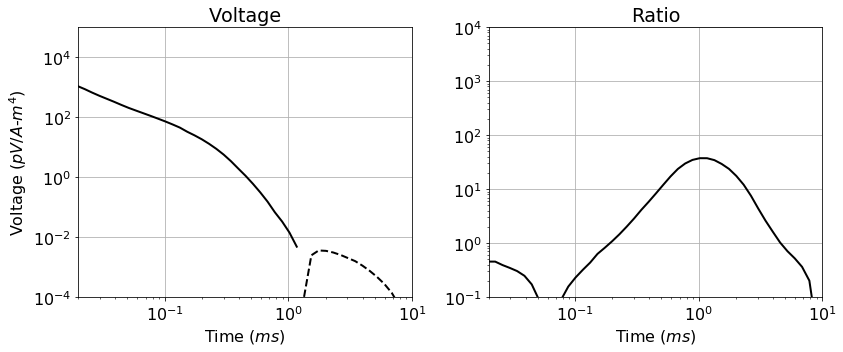

In [33]:
fig = plt.figure(figsize = (12, 5))
ax = plt.subplot(121)
ax1 = plt.subplot(122)
legends = ['Clays or Kimberlites', 'Sulphides (< 0.3 mm)']
ms = 1e3
colors = ["k", "b", "r", "g", 'y', 'purple', 'grey', 'skyblue', 'seagreen']
for i in range(1):
    data_p, data_n = get_dobs_pn(data_list_typeA[i].flatten()/moment)
    ax.loglog(rx_emip.times*ms, data_n, linestyle='-', color=colors[i], lw=2)
# ax.legend(legends)
for i in range(1):
    data_p, data_n = get_dobs_pn(data_list_typeA[i].flatten()/moment)
    ax.loglog(rx_emip.times*ms, data_p, linestyle='--', color=colors[i], lw=2)
    
for i in range(1):
    ax1.loglog(rx_emip.times*ms, abs(data_ip_list_typeA[i].flatten()/data_em_list_typeA[i].flatten()), linestyle='-', color=colors[i], lw=2)
for ax_temp in [ax, ax1]:
    ax_temp.set_xlabel("Time ($ms$)")        
    ax_temp.set_xlim(2e-5*ms, 0.01*ms)
    ax_temp.grid()
ax.set_ylabel("Voltage ($pV/A$-$m^4$)")    
ax.set_ylim(1e-4, 1e5)
ax1.set_ylim(1e-1, 1e4)
plt.tight_layout()    
ax.set_title("Voltage")
ax1.set_title("Ratio")

## TypeB: Clay (finer), Sulphide (finer)

In [34]:
cs, ncx, ncz, npad = 10., 25, 20, 20
hx = [(cs,ncx), (cs,npad,1.3)]
hz = [(cs,npad,-1.3), (cs,ncz), (cs,npad,1.3)]
mesh = Mesh.CylMesh([hx,1,hz], '00C')    
data_list_typeB = []
data_em_list_typeB = []
data_ip_list_typeB = []
for i in range(2):
    airind = mesh.gridCC[:,2]>0.
    blkind  = np.logical_and(mesh.gridCC[:,0]<200., (mesh.gridCC[:,2]<0)&(mesh.gridCC[:,2]>-150)&(mesh.gridCC[:,2]<-50))    
    sigmaInf[airind] = 1e-8
    if i==0:
        sig_2 = 1./50
        sig_1 = 0.001
        eta_CC, tau_CC, c_CC = 0.1, 0.0005, 0.7
    else:
        sig_2 = 1./50
        sig_1 = 0.001
        eta_CC, tau_CC, c_CC = 0.2, 0.0001, 0.3
        
    sigmaInf = np.ones(mesh.nC) * sig_1
    sigmaInf[blkind] = sig_2
    eta = np.zeros(mesh.nC)
    eta[blkind] = eta_CC
    tau = np.ones(mesh.nC) * tau_CC
    c = np.ones(mesh.nC) * c_CC 

    rx_emip = Rx.Point_dbdt(rxloc, np.logspace(np.log10(1e-5), np.log10(0.009), 51), 'z')
    src_emip = EM.TDEM.Src.CircularLoop([rx_emip], waveform=EM.TDEM.Src.StepOffWaveform(), loc=srcloc, radius = 13.)
    survey_emip = Survey([src_emip])
    prb_emip = Problem3D_e(mesh, sigmaInf=sigmaInf, eta=eta, tau=tau, c=c)
    prb_emip.timeSteps = [(1e-06, 5), (2.5e-06, 5), (5e-06, 5), (1e-05, 10), (2e-05, 10), (4e-05, 10), (8e-05, 10), (1.6e-04, 10), (3.2e-04, 20)]
    prb_emip.Solver = PardisoSolver
    prb_emip.pair(survey_emip)
    m = np.r_[sigmaInf, eta, tau, c]
    data = survey_emip.dpred(m)
    data_list_typeB.append(data) 

    rx_em = EM.TDEM.Rx.Point_dbdt(rxloc, np.logspace(np.log10(1e-5), np.log10(0.009), 51), 'z')
    src_em = EM.TDEM.Src.CircularLoop([rx_em], waveform=EM.TDEM.Src.StepOffWaveform(), loc=srcloc, radius = 13.)
    survey_em = EM.TDEM.Survey([src_em])
    prb_em = EM.TDEM.Problem3D_e(mesh, sigma=sigmaInf)
    prb_em.timeSteps = [(1e-06, 5), (2.5e-06, 5), (5e-06, 5), (1e-05, 10), (2e-05, 10), (4e-05, 10), (8e-05, 10), (1.6e-04, 10), (3.2e-04, 20)]
    prb_em.Solver = PardisoSolver
    prb_em.pair(survey_em)
    m = np.r_[sigmaInf, eta, tau, c]
    data_em_list_typeB.append(survey_em.dpred(m))
    data_ip_list_typeB.append(data - data_em)

Text(0.5, 1, 'Ratio')

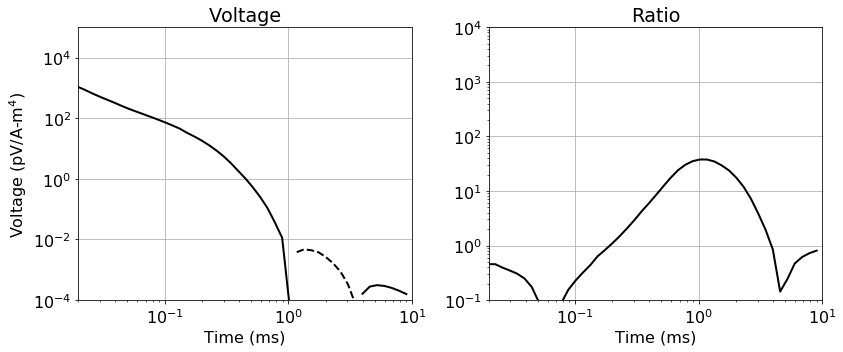

In [35]:
fig = plt.figure(figsize = (12, 5))
ax = plt.subplot(121)
ax1 = plt.subplot(122)
legends = ['Fine-grained clays', 'Fine-grained sulphides']
ms = 1e3
colors = ["k", "b", "r", "g", 'y', 'purple', 'grey', 'skyblue', 'seagreen']
for i in range(1):
    data_p, data_n = get_dobs_pn(data_list_typeB[i].flatten()/moment)
    ax.loglog(rx_emip.times*ms, data_n, linestyle='-', color=colors[i], lw=2)
# ax.legend(legends)
for i in range(1):
    data_p, data_n = get_dobs_pn(data_list_typeB[i].flatten()/moment)
    ax.loglog(rx_emip.times*ms, data_p, linestyle='--', color=colors[i], lw=2)
    
for i in range(1):
    ax1.loglog(rx_emip.times*ms, abs(data_ip_list_typeB[i].flatten()/data_em_list_typeA[i].flatten()), linestyle='-', color=colors[i], lw=2)
for ax_temp in [ax, ax1]:
    ax_temp.set_xlabel("Time (ms)")        
    ax_temp.set_xlim(2e-5*ms, 0.01*ms)
    ax_temp.grid()
ax.set_ylabel("Voltage (pV/A-m$^4$)")    
ax.set_ylim(1e-4, 1e5)
ax1.set_ylim(1e-1, 1e4)
plt.tight_layout()    
ax.set_title("Voltage")
ax1.set_title("Ratio")

In [46]:
cs, ncx, ncz, npad = 10., 25, 20, 20
hx = [(cs,ncx), (cs,npad,1.3)]
hz = [(cs,npad,-1.3), (cs,ncz), (cs,npad,1.3)]
mesh = Mesh.CylMesh([hx,1,hz], '00C')    
data_list_typeC = []
data_em_list_typeC = []
data_ip_list_typeC = []
for i in range(2):
    airind = mesh.gridCC[:,2]>0.
    blkind  = np.logical_and(mesh.gridCC[:,0]<200., (mesh.gridCC[:,2]<0)&(mesh.gridCC[:,2]>-150)&(mesh.gridCC[:,2]<-50))    
    blkind_1  = np.logical_and(mesh.gridCC[:,0]<np.Inf, (mesh.gridCC[:,2]<0)&(mesh.gridCC[:,2]>-400)&(mesh.gridCC[:,2]<-300))        
    sigmaInf[airind] = 1e-8
    if i==0:
        sig_2 = 1./50
        sig_1 = 0.001
        eta_CC, tau_CC, c_CC = 0.1, 0.001, 0.7
    else:
        sig_2 = 1./50
        sig_1 = 0.001
        eta_CC, tau_CC, c_CC = 0.2, 0.0001, 0.3
        
    sigmaInf = np.ones(mesh.nC) * sig_1
    sigmaInf[blkind] = sig_2
    sigmaInf[blkind_1] = 1./100.
    eta = np.zeros(mesh.nC)
    eta[blkind] = eta_CC
    tau = np.ones(mesh.nC) * tau_CC
    c = np.ones(mesh.nC) * c_CC 

    rx_emip = Rx.Point_dbdt(rxloc, np.logspace(np.log10(1e-5), np.log10(0.009), 51), 'z')
    src_emip = EM.TDEM.Src.CircularLoop([rx_emip], waveform=EM.TDEM.Src.StepOffWaveform(), loc=srcloc, radius = 13.)
    survey_emip = Survey([src_emip])
    prb_emip = Problem3D_e(mesh, sigmaInf=sigmaInf, eta=eta, tau=tau, c=c)
    prb_emip.timeSteps = [(1e-06, 5), (2.5e-06, 5), (5e-06, 5), (1e-05, 10), (2e-05, 10), (4e-05, 10), (8e-05, 10), (1.6e-04, 10), (3.2e-04, 20)]
    prb_emip.Solver = PardisoSolver
    prb_emip.pair(survey_emip)
    m = np.r_[sigmaInf, eta, tau, c]
    data = survey_emip.dpred(m)
    data_list_typeC.append(data) 

    rx_em = Rx.Point_dbdt(rxloc, np.logspace(np.log10(1e-5), np.log10(0.009), 51), 'z')
    src_em = EM.TDEM.Src.CircularLoop([rx_em], waveform=EM.TDEM.Src.StepOffWaveform(), loc=srcloc, radius = 13.)
    survey_em = Survey([src_em])
    prb_em = Problem3DEM_e(mesh, sigma=sigmaInf)
    prb_em.timeSteps = [(1e-06, 5), (2.5e-06, 5), (5e-06, 5), (1e-05, 10), (2e-05, 10), (4e-05, 10), (8e-05, 10), (1.6e-04, 10), (3.2e-04, 20)]
    prb_em.Solver = PardisoSolver
    prb_em.pair(survey_em)
    m = np.r_[sigmaInf, eta, tau, c]
    data_em_list_typeC.append(survey_em.dpred(m))
    data_ip_list_typeC.append(data - data_em)

Text(0.5, 1, 'Ratio')

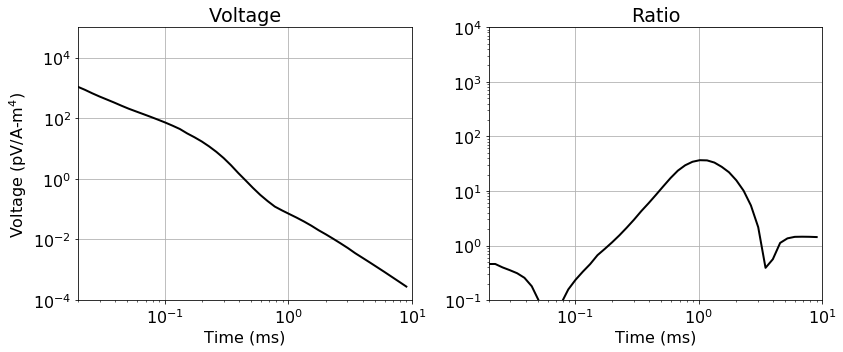

In [48]:
fig = plt.figure(figsize = (12, 5))
ax = plt.subplot(121)
ax1 = plt.subplot(122)
legends = ['Fine-grained clays', 'Fine-grained sulphides']
ms = 1e3
colors = ["k", "b", "r", "g", 'y', 'purple', 'grey', 'skyblue', 'seagreen']
for i in range(1):
    data_p, data_n = get_dobs_pn(data_list_typeC[i].flatten()/moment)
    ax.loglog(rx_emip.times*ms, data_n, linestyle='-', color=colors[i], lw=2)
# ax.legend(legends)
for i in range(1):
    data_p, data_n = get_dobs_pn(data_list_typeC[i].flatten()/moment)
    ax.loglog(rx_emip.times*ms, data_p, linestyle='--', color=colors[i], lw=2)
    
for i in range(1):
    ax1.loglog(rx_emip.times*ms, abs(data_ip_list_typeC[i].flatten()/data_em_list_typeA[i].flatten()), linestyle='-', color=colors[i], lw=2)
for ax_temp in [ax, ax1]:
    ax_temp.set_xlabel("Time (ms)")        
    ax_temp.set_xlim(2e-5*ms, 0.01*ms)
    ax_temp.grid()
ax.set_ylabel("Voltage (pV/A-m$^4$)")    
ax.set_ylim(1e-4, 1e5)
ax1.set_ylim(1e-1, 1e4)
plt.tight_layout()    
ax.set_title("Voltage")
ax1.set_title("Ratio")

In [49]:
cs, ncx, ncz, npad = 10., 25, 20, 20
hx = [(cs,ncx), (cs,npad,1.3)]
hz = [(cs,npad,-1.3), (cs,ncz), (cs,npad,1.3)]
mesh = Mesh.CylMesh([hx,1,hz], '00C')    
data_list_typeD = []
data_em_list_typeD = []
data_ip_list_typeD = []
taus = 1./(2*np.pi*np.array([2000., 4000.]))
etas = [0.9, 0.8]
for i in range(2):
    airind = mesh.gridCC[:,2]>0.
    blkind  = np.logical_and(mesh.gridCC[:,0]<200., (mesh.gridCC[:,2]<0)&(mesh.gridCC[:,2]>-50)&(mesh.gridCC[:,2]<0.))    
    sigmaInf[airind] = 1e-8
    sig_2 = 1./1000.
    sig_1 = 1./10000.
    eta_CC, tau_CC, c_CC = etas[i], taus[i], 0.5       
    sigmaInf = np.ones(mesh.nC) * sig_1
    sigmaInf[blkind] = sig_2
    eta = np.zeros(mesh.nC)
    eta[blkind] = eta_CC
    tau = np.ones(mesh.nC) * tau_CC
    c = np.ones(mesh.nC) * c_CC 

    rx_emip = Rx.Point_dbdt(rxloc, np.logspace(np.log10(1e-5), np.log10(0.009), 51), 'z')
    src_emip = EM.TDEM.Src.CircularLoop([rx_emip], waveform=EM.TDEM.Src.StepOffWaveform(), loc=srcloc, radius = 13.)
    survey_emip = Survey([src_emip])
    prb_emip = Problem3D_e(mesh, sigmaInf=sigmaInf, eta=eta, tau=tau, c=c)
    prb_emip.timeSteps = [(1e-06, 5), (2.5e-06, 5), (5e-06, 5), (1e-05, 10), (2e-05, 10), (4e-05, 10), (8e-05, 10), (1.6e-04, 10), (3.2e-04, 20)]
    prb_emip.Solver = PardisoSolver
    prb_emip.pair(survey_emip)
    m = np.r_[sigmaInf, eta, tau, c]
    data = survey_emip.dpred(m)
    data_list_typeD.append(data) 

    rx_em = Rx.Point_dbdt(rxloc, np.logspace(np.log10(1e-5), np.log10(0.009), 51), 'z')
    src_em = EM.TDEM.Src.CircularLoop([rx_em], waveform=EM.TDEM.Src.StepOffWaveform(), loc=srcloc, radius = 13.)
    survey_em = Survey([src_em])
    prb_em = Problem3DEM_e(mesh, sigma=sigmaInf)
    prb_em.timeSteps = [(1e-06, 5), (2.5e-06, 5), (5e-06, 5), (1e-05, 10), (2e-05, 10), (4e-05, 10), (8e-05, 10), (1.6e-04, 10), (3.2e-04, 20)]
    prb_em.Solver = PardisoSolver
    prb_em.pair(survey_em)
    m = np.r_[sigmaInf, eta, tau, c]
    data_em_list_typeD.append(survey_em.dpred(m))
    data_ip_list_typeD.append(data - data_em)

In [50]:
import numpy as np

In [51]:
taus = 1./(2*np.pi*np.array([2000., 4000.]))

In [52]:
area = np.pi * 13**2
noise_floor = 5e-14 * 10**12 / area

In [53]:
noise_floor

9.417452253958304e-05

In [54]:
1./1e-3 *2 * np.pi

6283.185307179586

Text(0.5, 1, 'Ratio')

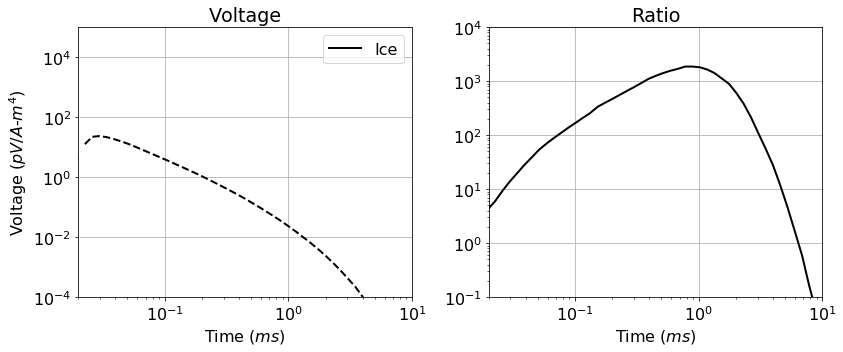

In [55]:
fig = plt.figure(figsize = (12, 5))
ax = plt.subplot(121)
ax1 = plt.subplot(122)
legends = ['Ice', 'Fine-grained sulphides']
ms = 1e3
colors = ["k", "b", "r", "g", 'y', 'purple', 'grey', 'skyblue', 'seagreen']
for i in range(1):
    data_p, data_n = get_dobs_pn(data_list_typeD[i].flatten()/moment)
    ax.loglog(rx_emip.times*ms, data_n, linestyle='-', color=colors[i], lw=2)
ax.legend(legends)
for i in range(1):
    data_p, data_n = get_dobs_pn(data_list_typeD[i].flatten()/moment)
    ax.loglog(rx_emip.times*ms, data_p, linestyle='--', color=colors[i], lw=2)
    
for i in range(1):
    ax1.loglog(rx_emip.times*ms, abs(data_ip_list_typeD[i].flatten()/data_em_list_typeD[i].flatten()), linestyle='-', color=colors[i], lw=2)
for ax_temp in [ax, ax1]:
    ax_temp.set_xlabel("Time ($ms$)")        
    ax_temp.set_xlim(2e-5*ms, 0.01*ms)
    ax_temp.grid()
ax.set_ylabel("Voltage ($pV/A$-$m^4$)")    
ax.set_ylim(1e-4, 1e5)
ax1.set_ylim(1e-1, 1e4)
plt.tight_layout()    
ax.set_title("Voltage")
ax1.set_title("Ratio")

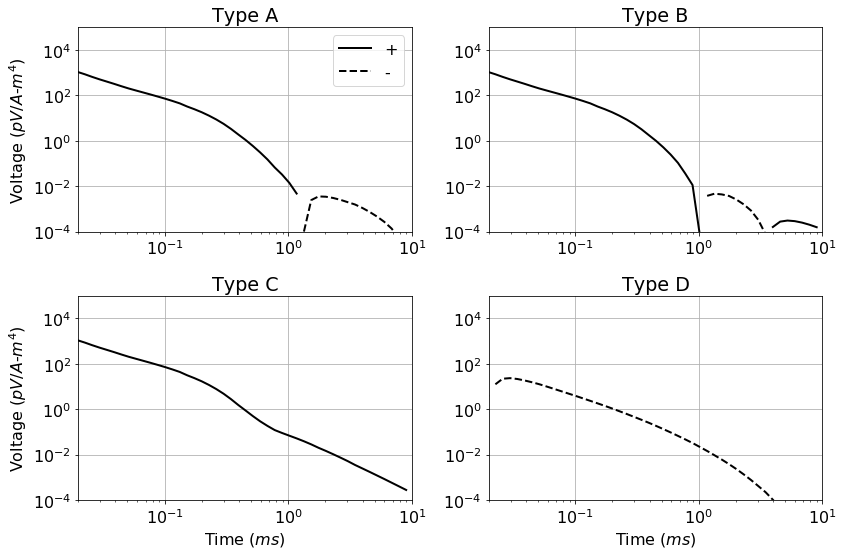

In [56]:
fig = plt.figure(figsize = (12, 8))
ax1 = plt.subplot(221)
ax2 = plt.subplot(222)
ax3 = plt.subplot(223)
ax4 = plt.subplot(224)
legends = ['Fine-grained clays', 'Fine-grained sulphides']
ms = 1e3
i=0
colors = ["k", "b", "r", "g", 'y', 'purple', 'grey', 'skyblue', 'seagreen']
data_p, data_n = get_dobs_pn(data_list_typeA[i].flatten()/moment)
ax1.loglog(rx_emip.times*ms, data_n, linestyle='-', color=colors[0], lw=2)
ax1.loglog(rx_emip.times*ms, data_p, linestyle='--', color=colors[0], lw=2)

data_p, data_n = get_dobs_pn(data_list_typeB[i].flatten()/moment)
ax2.loglog(rx_emip.times*ms, data_n, linestyle='-', color=colors[0], lw=2)
ax2.loglog(rx_emip.times*ms, data_p, linestyle='--', color=colors[0], lw=2)

data_p, data_n = get_dobs_pn(data_list_typeC[i].flatten()/moment)
ax3.loglog(rx_emip.times*ms, data_n, linestyle='-', color=colors[0], lw=2)
ax3.loglog(rx_emip.times*ms, data_p, linestyle='--', color=colors[0], lw=2)

data_p, data_n = get_dobs_pn(data_list_typeD[i].flatten()/moment)
ax4.loglog(rx_emip.times*ms, data_n, linestyle='-', color=colors[0], lw=2)
ax4.loglog(rx_emip.times*ms, data_p, linestyle='--', color=colors[0], lw=2)

titles = ['Type A', 'Type B', 'Type C', 'Type D']
for i, ax_temp in enumerate([ax1, ax2, ax3, ax4]):
    if i>1:
        ax_temp.set_xlabel("Time ($ms$)")     
    if i==0:
        ax_temp.legend(("+", "-"))
    ax_temp.set_xlim(2e-5*ms, 0.01*ms)
    ax_temp.grid()
    ax_temp.set_ylim(1e-4, 1e5)
    ax_temp.set_title(titles[i])
    if (i==0) or (i==2):
        ax_temp.set_ylabel("Voltage ($pV/A$-$m^4$)")    
ax.set_ylim(1e-4, 1e5)
plt.tight_layout()    
fig.savefig(figdir+"type_curves", dpi=300)